In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import subprocess


def get_git_root():
    """Get the root directory of the git repository"""
    try:
        git_root = (
            subprocess.check_output(
                ["git", "rev-parse", "--show-toplevel"], stderr=subprocess.DEVNULL
            )
            .strip()
            .decode("utf-8")
        )
        return git_root
    except (subprocess.CalledProcessError, FileNotFoundError):
        return None


# Change to git root
git_root = get_git_root()
if git_root:
    os.chdir(git_root)
    print(f"Changed to git root: {os.getcwd()}")
else:
    print("Not in a git repository or git not found")

Changed to git root: /Users/sherman/GitHub/CSE-6748


In [3]:
import pickle

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [4]:
X_index = pd.read_parquet("data/cleaned/X_index.parquet")
X = pd.read_parquet("data/cleaned/X.parquet")
Y = pd.read_parquet("data/cleaned/Y.parquet")

In [14]:
# Train/test split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=69,
)

X_train.to_parquet("data/cleaned/X_train.parquet")
X_valid.to_parquet("data/cleaned/X_valid.parquet")
Y_train.to_parquet("data/cleaned/Y_train.parquet")
Y_valid.to_parquet("data/cleaned/Y_valid.parquet")

In [6]:
# # Define the parameter grid to search
# param_dist = {
#     "iterations": randint(1000, 5000),  # Number of trees
#     "learning_rate": uniform(0.01, 0.2),  # Learning rate
#     "depth": randint(4, 10),  # Depth of trees
#     "l2_leaf_reg": uniform(1, 10),  # L2 regularization
#     "random_strength": uniform(0.1, 1.0),  # Random strength for split
#     "bagging_temperature": uniform(0, 1),  # Bagging temperature for features
#     "border_count": randint(32, 255),  # Border count for splits
# }

# # Set up the CatBoost model for cross-validation
# cv_model = CatBoostRegressor(
#     loss_function="MultiRMSE",
#     eval_metric="MultiRMSE",
#     random_seed=42,
#     verbose=0,
#     task_type="CPU",
# )

# # Create the RandomizedSearchCV object
# search = RandomizedSearchCV(
#     estimator=cv_model,
#     param_distributions=param_dist,
#     n_iter=100,  # Number of parameter settings to try
#     cv=5,  # 5-fold cross-validation
#     scoring="neg_root_mean_squared_error",
#     random_state=42,
#     n_jobs=-1,  # Use all available processors
#     verbose=2,
# )

# print("Starting hyperparameter search with cross-validation. This may take a while...")


# # Fit the RandomizedSearchCV
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
# search.fit(X_train, Y_train, cat_features=categorical_features)

# # Print the best parameters
# print("\nBest parameters found:")
# print(search.best_params_)
# print(f"\nBest cross-validation RMSE: {-search.best_score_:.4f}")

In [7]:
# Train a new model with the best parameters
best_model = CatBoostRegressor(
    # **search.best_params_,
    iterations=5000,
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    random_seed=42,
    verbose=500,
)

# Fit the model with best parameters
best_model.fit(
    X_train,
    Y_train,
    eval_set=[(X_valid, Y_valid)],
    cat_features=categorical_features,
)

0:	learn: 168.4307184	test: 167.4504397	best: 167.4504397 (0)	total: 77.7ms	remaining: 6m 28s
500:	learn: 83.3274310	test: 86.7220671	best: 86.7220671 (500)	total: 11s	remaining: 1m 38s
1000:	learn: 79.1982762	test: 85.7277179	best: 85.7277179 (1000)	total: 22s	remaining: 1m 28s
1500:	learn: 76.2926122	test: 85.3377998	best: 85.3377998 (1500)	total: 33.8s	remaining: 1m 18s
2000:	learn: 73.9273683	test: 85.1437895	best: 85.1391006 (1991)	total: 46.9s	remaining: 1m 10s
2500:	learn: 71.7439808	test: 85.0842370	best: 85.0841015 (2498)	total: 57.1s	remaining: 57.1s
3000:	learn: 69.8016408	test: 85.1151899	best: 85.0723567 (2613)	total: 1m 5s	remaining: 43.5s
3500:	learn: 67.9958151	test: 85.1857170	best: 85.0723567 (2613)	total: 1m 13s	remaining: 31.5s
4000:	learn: 66.3903789	test: 85.2394151	best: 85.0723567 (2613)	total: 1m 21s	remaining: 20.4s
4500:	learn: 64.8514624	test: 85.3216610	best: 85.0723567 (2613)	total: 1m 29s	remaining: 9.95s
4999:	learn: 63.4162273	test: 85.3930662	best: 85.

In [8]:
# Save the CatBoost model to a pickle file
with open("models/catboost_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("CatBoost model saved as pickle to models/catboost_model.pkl")

CatBoost model saved as pickle to models/catboost_model.pkl


In [9]:
# Load the model from pickle
with open("models/catboost_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
# Predict & evaluate
y_pred_best = best_model.predict(X_valid)
rmse_best = np.sqrt(mean_squared_error(Y_valid, y_pred_best))

print(f"Tuned CatBoost RMSE: {rmse_best:.4f}")

Tuned CatBoost RMSE: 60.1552


In [ ]:
y_pred_int = np.round(y_pred_best, 0).astype(int)

# Create comparison DataFrame
comparison_df = pd.merge(
    X_index,
    pd.DataFrame(
        {
            "sat_math_score": Y_valid["sat_math_score"],
            "sat_verbal_score": Y_valid["sat_verbal_score"],
            "pred_sat_math_score": y_pred_int[:, 0],
            "pred_sat_verbal_score": y_pred_int[:, 1],
        }
    ),
    left_index=True,
    right_index=True,
    how="right",
)

comparison_df

,mask_studentpersonkey,sat_math_score,sat_verbal_score,pred_sat_math_score,pred_sat_verbal_score
5864,311825,550,620,609,619
2522,257286,340,370,439,442
5940,312094,380,380,428,446
6085,312572,770,650,729,657
4603,296587,430,540,513,511
...,...,...,...,...,...
11134,425009,730,650,627,637
8725,353953,410,590,471,520
5132,300454,500,510,489,493
10742,410747,470,490,557,535


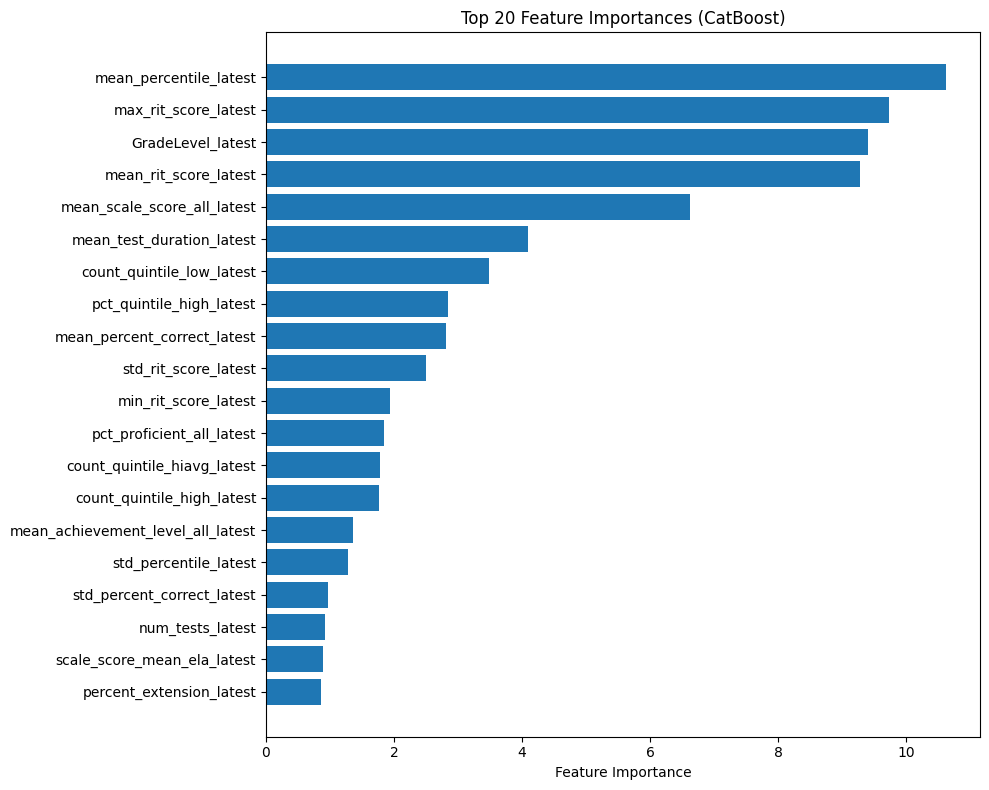

In [ ]:
# Get feature importance (default is 'PredictionValuesChange')
feature_importance = best_model.get_feature_importance()

# Create a DataFrame for better visualization
feature_names = X.columns
importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (CatBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()